In [1]:
import torch 
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


In [2]:
classes = ['Non-Masked', 'Masked']

In [3]:
REBUILD_DATA = True

if REBUILD_DATA: 
    data_path = Path('C:\Dataset\self-built-masked-face-recognition-dataset')
    maskPath = data_path/'AFDB_masked_face_dataset'
    nonMaskPath = data_path/'AFDB_face_dataset'
    maskDF = pd.DataFrame() 
    path_dirs = [ [maskPath,1],[nonMaskPath,0] ] #path and label
    if not os.path.exists(data_path):
        raise Exception("The data path doesn't exist")

In [4]:

class MaskvNoMask():
    IMG_SIZE = 100
    LABELS = {'NON_MASKED': 0, 'MASKED': 1}
    training_data = []
    
    count = 0
    
    def make_training_data(self):
        for data_dir, label in path_dirs:
            print('Reading from: ',label)
            for folder in tqdm(os.listdir(data_dir)):
                folder_path = os.path.join(data_dir, folder)
                for imgpath in os.listdir(folder_path):
                    self.count += 1                       
                    img_path = os.path.join(folder_path, imgpath)
                    try:
                        img = cv2.imread(img_path)
                        img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                        self.training_data.append([np.array(img), label])
                        self.count +=1
                        
                        if label == 1:
                            self.LABELS['MASKED'] += 1
                        if label == 0:
                            self.LABELS['NON_MASKED'] +=1
                    
                    except:
#                         raise Exception('error: {}'.format(img_path))
                        pass
            print(self.LABELS)
#                         raise Exception('error occured while reading , {}'.format(os.path.join(maskPath, os.path.join(subject, imgPath))))
                        
        
        np.random.shuffle(self.training_data)

        
if REBUILD_DATA:
    maskvnomask = MaskvNoMask()
    maskvnomask.make_training_data()
    training_data = maskvnomask.training_data


  0%|                                                                                          | 0/595 [00:00<?, ?it/s]

Reading from:  1


  0%|▏                                                                                 | 1/460 [00:00<00:51,  8.87it/s]

{'NON_MASKED': 0, 'MASKED': 69198}
Reading from:  0


100%|████████████████████████████████████████████████████████████████████████████████| 460/460 [01:05<00:00,  6.97it/s]

{'NON_MASKED': 90468, 'MASKED': 69198}


In [5]:
training_data[0][0].shape #training_data.shape, 'list' object has no attribute 'shape' 


(100, 100, 3)

In [6]:
training_data


[[array([[[ 31,  38,  31],
          [ 32,  40,  32],
          [ 33,  40,  33],
          ...,
          [111, 141, 198],
          [109, 141, 200],
          [122, 150, 210]],
  
         [[ 37,  44,  39],
          [ 39,  46,  41],
          [ 38,  48,  42],
          ...,
          [120, 150, 206],
          [138, 161, 213],
          [157, 181, 231]],
  
         [[ 32,  38,  33],
          [ 32,  39,  32],
          [ 33,  40,  33],
          ...,
          [123, 150, 206],
          [138, 164, 218],
          [148, 172, 223]],
  
         ...,
  
         [[221, 219, 209],
          [193, 192, 188],
          [213, 212, 200],
          ...,
          [118, 109, 102],
          [127, 117, 110],
          [113, 103,  96]],
  
         [[193, 189, 188],
          [210, 206, 195],
          [208, 207, 197],
          ...,
          [137, 132, 130],
          [118, 106, 102],
          [115, 105,  99]],
  
         [[174, 168, 161],
          [207, 207, 191],
          [210, 207, 199

Masked


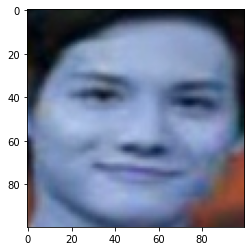

In [7]:
plt.imshow(training_data[6][0])
print(classes[training_data[1][1]])

In [8]:
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor

In [9]:
class MaskDataset(Dataset):
        """ Masked faces dataset
        0 = 'no mask'
        1 = 'mask'
        """
        def __init__(self, train_data):
            self.train_data = train_data
            #https://pytorch.org/vision/stable/transforms.html
            self.transformations = Compose([
                ToTensor(),
            ])
        
        def __getitem__(self, key): #for understanding get item = https://www.programmersought.com/article/98542425111/
            if isinstance(key, slice):
                raise NotImplementedError('slicing is not supported')                    
            return [
                self.transformations(self.train_data[key][0]),
                torch.tensor(self.train_data[key][1]) 
            ]
        
        def __len__(self):
            return len(self.train_data)

In [10]:
myDataset = MaskDataset(training_data)

In [11]:
def show_example(data):
    img, label = data
    print('Label: ', classes[int(label.item())], "("+str(label.item())+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Non-Masked (0)


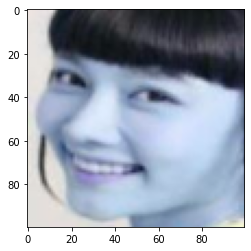

In [12]:
show_example(myDataset[55])

In [13]:
myDataset[1001]

[tensor([[[0.7490, 0.7451, 0.7333,  ..., 0.8824, 0.8863, 0.8941],
          [0.6824, 0.6667, 0.6510,  ..., 0.8902, 0.9020, 0.9059],
          [0.6314, 0.6275, 0.6392,  ..., 0.9020, 0.9137, 0.9137],
          ...,
          [0.9765, 0.9765, 0.9804,  ..., 1.0000, 1.0000, 0.9882],
          [0.9098, 0.9098, 0.9098,  ..., 1.0000, 1.0000, 0.9843],
          [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 0.9569]],
 
         [[0.7961, 0.7922, 0.7882,  ..., 0.9216, 0.9294, 0.9373],
          [0.7451, 0.7294, 0.7176,  ..., 0.9333, 0.9373, 0.9412],
          [0.6980, 0.6941, 0.7059,  ..., 0.9451, 0.9490, 0.9529],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.6510, 0.6196, 0.6157],
          [0.9922, 0.9922, 0.9922,  ..., 0.6627, 0.6235, 0.6078],
          [1.0000, 1.0000, 1.0000,  ..., 0.6667, 0.6431, 0.5765]],
 
         [[0.8667, 0.8627, 0.8627,  ..., 0.9608, 0.9608, 0.9686],
          [0.8275, 0.8196, 0.8196,  ..., 0.9647, 0.9725, 0.9765],
          [0.8039, 0.8000, 0.8078,  ...,

In [14]:
img, label = myDataset[1001]
print(img.shape)
print(label)

torch.Size([3, 100, 100])
tensor(1)


In [15]:
val_size = 1000
train_size = len(myDataset) - val_size

train_ds, val_ds = torch.utils.data.random_split(myDataset, [train_size, val_size])#train_test_split
len(train_ds), len(val_ds)

(158665, 1000)

Label:  Masked (1)


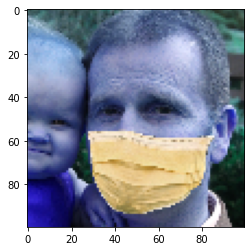

In [16]:
show_example(val_ds[77])

In [17]:
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
batch_size = 32

In [18]:
train_dl = DataLoader(train_ds, batch_size=batch_size*2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2)


In [19]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [20]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

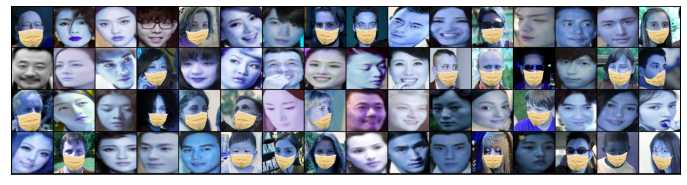

In [21]:
show_batch(train_dl)

In [22]:
input_size = 100*100 # We need to change this parameter wrt convolutional network??
output_size = 2

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels.long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    def predict():
        pred = model(img)
        _, preds = torch.max(pred, dim=1)

In [25]:
class MaskDetection(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(160000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2))
        
    def forward(self, xb):
        return self.network(xb) # xb = weights and biases

In [26]:
class MaskDetection1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 4 x 4

            nn.Flatten(), 
            nn.Linear(80000, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2))
        
            
        
    def forward(self, xb):
        return self.network(xb) # xb = weights and biases
    
    

In [27]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:

"""alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
mnasnet = models.mnasnet1_0(pretrained=True)""";

In [29]:
torch.cuda.is_available()

True

In [30]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
def to_device(data, device):
    #move tensors to device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [33]:
train_dl

In [34]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([64, 3, 100, 100])
cuda:0


In [35]:
class DeviceDataLoader():
    #move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batchs
        return len(self.dl)

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [37]:
for xb, yb in val_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')


In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epochs): 
        print('epoch: ', epoch)
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
# Model (on GPU)
model = MaskDetection1()
#model.load_state_dict(torch.load('../output/MaskDetection.pth'))
to_device(model, device)

MaskDetection1(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=80000, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [40]:
#model.load_state_dict(torch.load('./MaskDetection.pth'))
model.eval()

MaskDetection1(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=80000, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [41]:
sum(p.numel() for p in model.parameters())

82016322

In [42]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoints")
torch.save(model.state_dict(), checkpoint_path)

In [44]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6943820714950562, 'val_acc': 0.42890626192092896}]

In [45]:
epoch = 1
history = fit(epoch, 1e-3, model, train_dl, val_dl)

epoch:  0
Epoch [0], train_loss: 0.0398, val_loss: 0.0085, val_acc: 0.9980


In [46]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [47]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

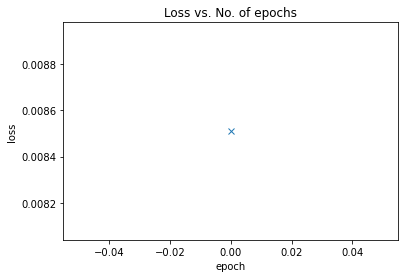

In [48]:
plot_losses(history)

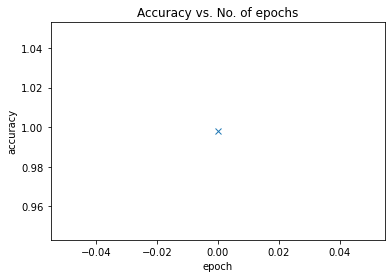

In [49]:
plot_accuracies(history)

In [50]:

          
import matplotlib.image as mpimg
def singleImage(path, label= None, show= False):
    img = cv2.imread(path)
    assert img is not None,"Immage wasn't read properly"
    img = cv2.resize(img, (100, 100))
    img = torch.from_numpy(img)
    img = img.permute((2, 0,1)) # model expects image to be of shape [3, 100, 100]
    img = img.unsqueeze(dim=0).float() # convert single image to batch [1, 3, 100, 100]
    img = img.to('cuda') # Using the same device as the model
    pred = model(img)
    _, preds = torch.max(pred, dim=1)
    print(classes[preds.item()])
    # plt.imshow(img.squeeze(dim=0).permute((1,2,0)).to('cpu'))

    if show:
        plt.imshow(mpimg.imread(path))
        print("the image is :" + classes[preds.item()])

In [51]:
def valImage(key, show = True):
    img = val_ds[key][0]
    pred = model(img.unsqueeze(dim=0).to(device))
    _, preds = torch.max(pred, dim=1)
    cv2.imshow('',img.permute(1, 2,0), cmap=cm.bgr)
    print("predicted:",classes[preds.item()])
    print("Actual:",classes[val_ds[key][1]])    

Masked
the image is :Masked


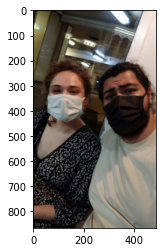

In [52]:
singleImage(r'C:\Users\cagla\Desktop\test\a2.jpg', show=True)

In [53]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[569.,   0.],
        [  2., 429.]])


In [54]:
#Daha fazla variable olsa for döngüsü ile yapılması daha mantıklı ancak 2 tane variableımız oldugu için manuel yaptık
True_Positive = confusion_matrix[0, 0]
True_Negative = confusion_matrix[1, 1]
False_Positive = confusion_matrix[1, 0]
False_Negative = confusion_matrix[0, 1]
TP = True_Positive
TN = True_Negative
FN = False_Negative
FP = False_Positive

Precision = (TP)/(TP + FP)
Recall = (TP)/(TP + FN)

F1_score = 2*(Precision*Recall)/(Precision+Recall)

In [55]:
accuracy = (TP + TN)/(TP+TN+FP+FN)
accuracy

tensor(0.9980)

In [56]:
F1_score

tensor(0.9982)

In [57]:
import cv2
VIDEO_STREAM = r"C:\Users\cagla\Desktop\video\mask_video.mp4"
VIDEO_STREAM_OUT = "result.mp4"
vs = cv2.VideoCapture(VIDEO_STREAM)

In [58]:
length = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )

1033


In [2]:
import cv2
import os
results={0:'without mask', 1:'mask'}
faceCascade = cv2.CascadeClassifier(r'C:\Users\cagla\anaconda3\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')
video_capture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    for (x,y,w,h) in faces:
        
        cv2.rectangle(frame, (x, y), (x + w, y + h),(0,255,0), 2)
        # Display the resulting frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, 
                results[0], 
                (50, 50), 
                font, 1, 
                (0, 255, 255), 
                2, 
                cv2.LINE_4)
    cv2.imshow('Video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

In [61]:
yuklenmis_model = torch.load(checkpoint_path)

In [62]:
yuklenmis_model

OrderedDict([('network.0.weight',
              tensor([[[[-0.1813, -0.0433,  0.0713],
                        [-0.0142, -0.0563, -0.0606],
                        [-0.0359, -0.0311,  0.0669]],
              
                       [[ 0.0798, -0.0580, -0.1221],
                        [-0.1576, -0.1831, -0.0405],
                        [-0.1318, -0.0637,  0.1763]],
              
                       [[-0.1187, -0.1121, -0.0601],
                        [ 0.1375,  0.0017, -0.0256],
                        [ 0.0969, -0.0644,  0.1531]]],
              
              
                      [[[ 0.1301,  0.1434,  0.0891],
                        [ 0.0384,  0.1307, -0.1706],
                        [-0.0864,  0.0169,  0.0549]],
              
                       [[ 0.1641, -0.0193, -0.0395],
                        [ 0.1293,  0.0467, -0.1373],
                        [-0.0657, -0.0352, -0.1045]],
              
                       [[-0.1088,  0.0273,  0.0390],
                      

In [97]:
import cv2
import numpy as np

model= yuklenmis_model

results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}

rect_size = 4
cap = cv2.VideoCapture(0) 


haarcascade = cv2.CascadeClassifier(r'C:\Users\cagla\anaconda3\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')

while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 

    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])

        result= model.predict(reshaped)

        
        label=np.argmax(result,axis=1)[0]
       
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break

cap.release()

cv2.destroyAllWindows()

AttributeError: 'collections.OrderedDict' object has no attribute 'predict'

In [8]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > args["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [16]:
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()


# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
			
		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...


NameError: name 'imutils' is not defined

In [10]:
from imutils.video import VideoStream